# A. Getting the Dataset

In [2]:
# #!/bin/bash
# mkdir -p ./ds/
# curl -L -o ./ds/7k-books-with-metadata.zip https://www.kaggle.com/api/v1/datasets/download/dylanjcastillo/7k-books-with-metadata

In [3]:
import pandas as pd

In [4]:
books = pd.read_csv("./ds/books.csv")
books.sample(5)

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count
3457,9780553297836,055329783X,A Whole New Light,NaN,Sandra Brown,Fiction,http://books.google.com/books/content?id=riEu7...,"When her late husband's business partner, Wort...",1992.0,3.55,227.0,2817.0
4654,9780761956921,0761956921,Société de Consommation,"Ses Mythes, Ses Structures",Jean Baudrillard,Social Science,http://books.google.com/books/content?id=Bbex0...,"Now available in English for the first time, J...",1998.0,4.13,224.0,654.0
2647,9780425213612,0425213617,Wicked Ties,NaN,Shayla Black,Fiction,http://books.google.com/books/content?id=sdVnW...,Hiring bodyguard Jack Cole when a stalker turn...,2007.0,3.96,341.0,22083.0
1092,9780156003650,0156003651,The Double Flame,Love and Eroticism,Octavio Paz,Literary Collections,http://books.google.com/books/content?id=yPGjT...,A collection of essays examines the themes of ...,1996.0,4.21,276.0,577.0
1119,9780156030489,0156030489,Kiffe Kiffe Tomorrow,NaN,Faïza Guène;Sarah Adams,Fiction,http://books.google.com/books/content?id=fv8tv...,"Struggling with an overworked mother, an absen...",2006.0,3.38,179.0,1026.0


# 1. EDA

### 1.1 Checking if there are null values in the DS

In [5]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6810 entries, 0 to 6809
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   isbn13          6810 non-null   int64  
 1   isbn10          6810 non-null   object 
 2   title           6810 non-null   object 
 3   subtitle        2381 non-null   object 
 4   authors         6738 non-null   object 
 5   categories      6711 non-null   object 
 6   thumbnail       6481 non-null   object 
 7   description     6548 non-null   object 
 8   published_year  6804 non-null   float64
 9   average_rating  6767 non-null   float64
 10  num_pages       6767 non-null   float64
 11  ratings_count   6767 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 638.6+ KB


In [6]:
# null_counts = books.isnull().sum()
# null_counts
# null_percent = (null_counts / len(books)) * 100

#or
null_percent = books.isnull().mean() * 100
null_percent.to_frame().T

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count
0,0.0,0.0,0.0,65.036711,1.057269,1.453744,4.831131,3.847283,0.088106,0.631424,0.631424,0.631424


In [7]:
unique_counts = books.nunique().to_frame().T
unique_counts

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count
0,6810,6810,6398,2009,3780,567,6481,6474,94,200,915,3881


#### What we are concerned about:
- a lot of subtitles are missing, approx 2/3 of total `which needs to be handled (removed or used)` [see here](#24-handling-missing-subtitles)
- too many categories, but `we might still want to use the category names as they might have valuable information`
- only 4% descriptions missing which is okay, but ` we want to check if the missing of description isn't biased`

> it is important to check if missing values have some pattern as it can imply some sort of bias.

### 1.2 Further investigating missing values

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

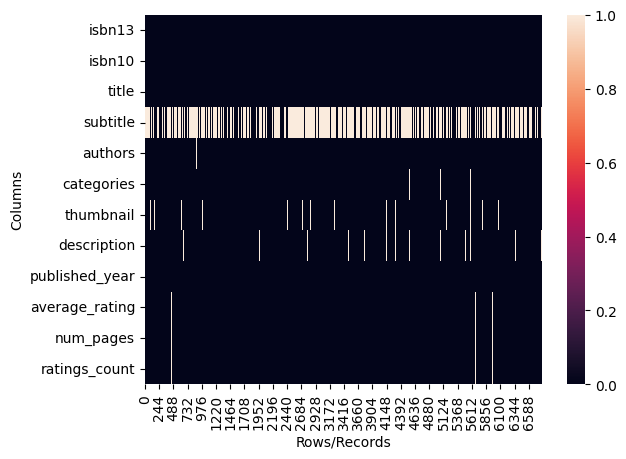

In [9]:

ax = plt.axes()
sns.heatmap(books.isna().T, cbar=True, ax =ax)
plt.xlabel("Rows/Records")
plt.ylabel("Columns")
plt.show()

> for the last three columns, when one value is missing, all of the values are missing. it could mean, the records were added from other smaller dataset that didn't contain those columns

### 1.3 Checking the correlation between missing description and other colums (like age, rating, number of pages)

In [10]:
import numpy as np

In [11]:

books["missing_description"] = np.where(books["description"].isnull(), 1, 0)
books["age"] = 2025 - books["published_year"]

In [12]:
cols_of_interest = ["missing_description", "age", "num_pages", "average_rating"]

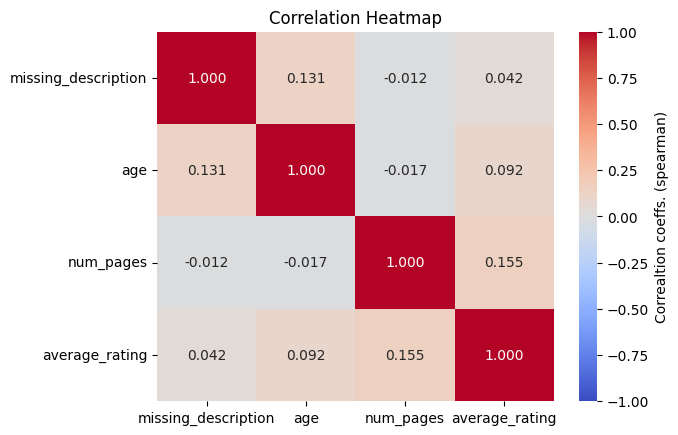

In [13]:
correlation_matrix = books[cols_of_interest].corr("spearman")
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".3f", cmap="coolwarm", vmin=-1, vmax=1, cbar_kws={"label": "Correaltion coeffs. (spearman)"})
heatmap.set_title("Correlation Heatmap")
plt.show()

> The missing_description seems to be uncorrelated with age, num_pages and average_rating. So, we can move on

# 2. Transforming

### 2.1 Removing the entries that have null values
**for description, num_pages, avg_rating and published year as they make up only a little `(<5%)` of our dataset**

In [14]:
invalid_entries = books[(books["description"].isna()) | (books["num_pages"].isna()) | (books["average_rating"].isna()) | (books["published_year"].isna())]
invalid_entries.shape

(303, 14)

In [15]:
valid_entries = books[~((books["description"].isna()) | (books["num_pages"].isna()) | (books["average_rating"].isna()) | (books["published_year"].isna()))].copy() #doing copy to create an independent copy of the dataframe
valid_entries.shape

(6507, 14)

### 2.2  Examining the categories column **(which has 500+ unique category calues)** and fixing it

In [16]:
category_count = valid_entries["categories"].value_counts().reset_index().sort_values("count", ascending=False)

> with matplotlib

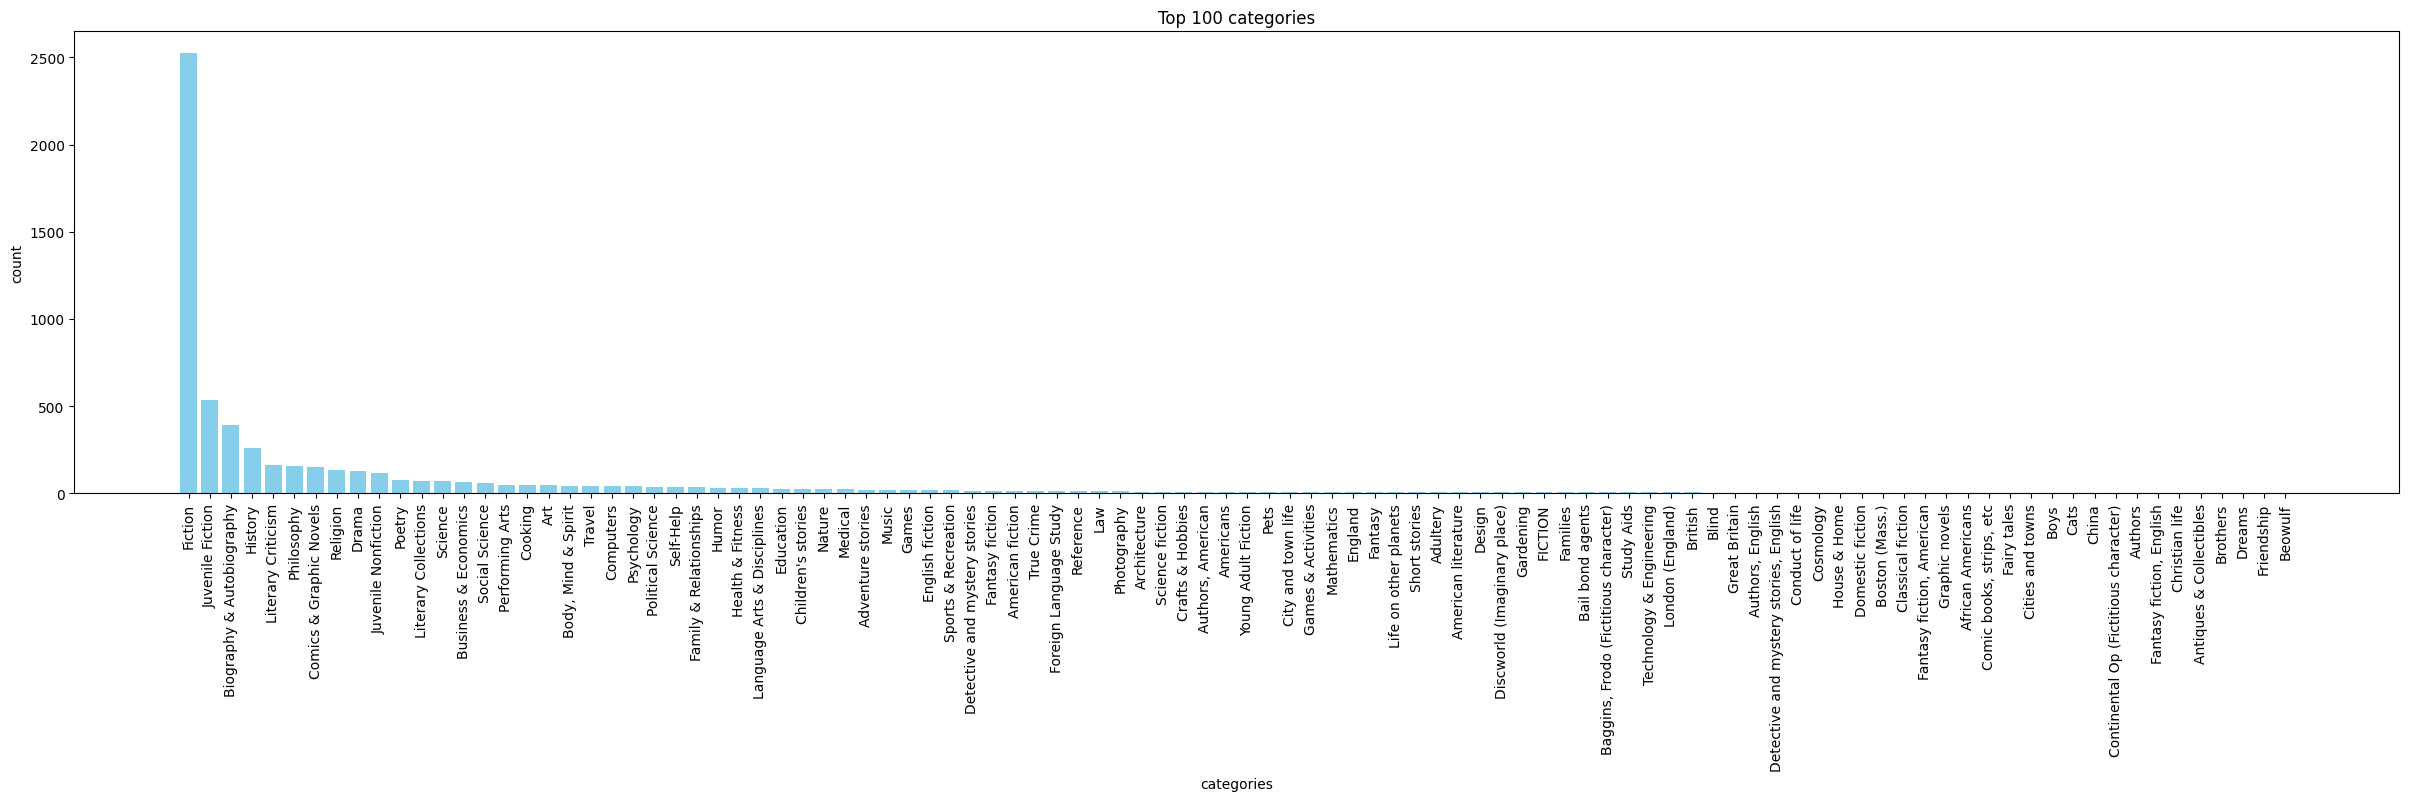

In [17]:

plt.figure(figsize=(30,6))
plt.bar(category_count["categories"][:100],category_count["count"][:100], color='skyblue')
plt.title('Top 100 categories')
plt.xlabel('categories')
plt.ylabel('count')

plt.xticks(rotation=90)

plt.show()

> with plotly

In [18]:
import plotly.express as px
import pandas as pd

# Sample DataFrame (replace with your actual data)
# category_count = pd.read_csv(...) or however you define it
# Must contain columns: 'categories' and 'count'

# Sort for clarity (optional)
category_count = category_count.sort_values('count', ascending=False).reset_index(drop=True)

# Create bar chart
fig = px.bar(
    category_count,
    x='categories',
    y='count',
    title='All Categories count',
    labels={'categories': 'Category', 'count': 'Count'},
    template='plotly_white'
)

# Adjust layout: auto-width based on number of categories
fig.update_layout(
    xaxis_tickangle=90,
    width=max(1000, len(category_count) * 5),  # Dynamically scale width
    height=500,
    title_font_size=24,
    yaxis_tickfont=dict(size=10, family='Courier New'),
    xaxis_tickfont=dict(size=8, family='Courier New'),
    margin=dict(l=40, r=40, t=80, b=40)
)

fig.show()


> so we need to fix this long tail distribution in categories column [as done here](#3-)

#### 2.3 Removing very short, grabage descriptions `<25 words`

In [ ]:
#getting description lengths into a column
# valid_entries["description_length"] = valid_entries["description"].str.split().str.len()
#or equivalently
valid_entries["description_length"] = valid_entries["description"].apply(lambda x: len(x.split()))

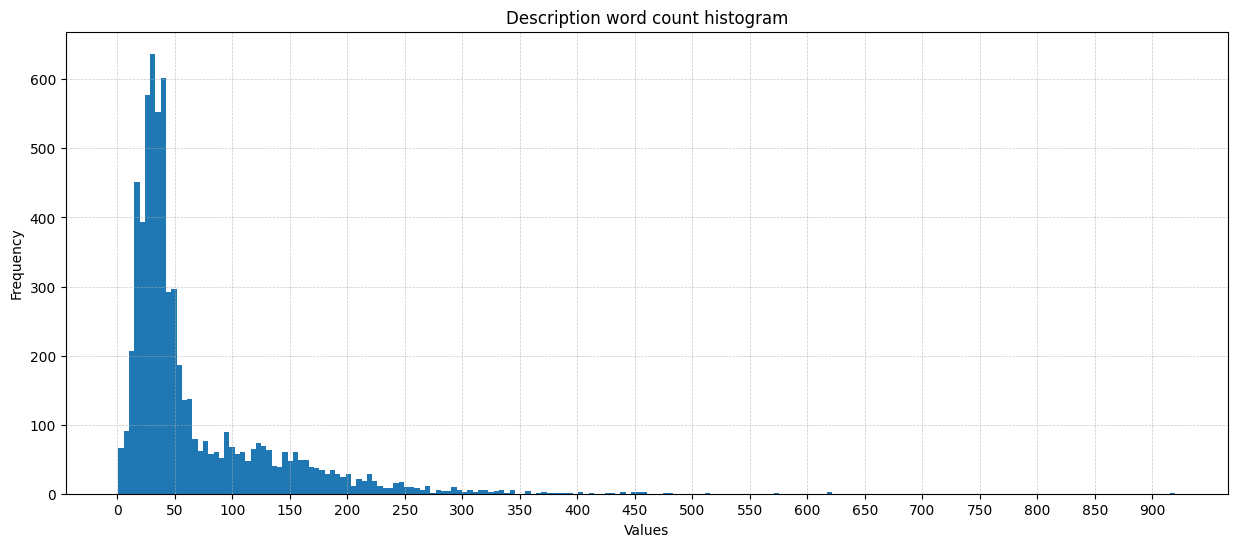

In [ ]:
#visualize how the description length is distributed

plt.figure(figsize=(15,6))
plt.hist(valid_entries["description_length"], bins=200, histtype="stepfilled")
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Description word count histogram')
plt.xticks(ticks=np.arange(0,valid_entries["description_length"].max(),50))
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

In [34]:
#checking how the description look like at different range of lengths

#.loc[row_index, col_index]
valid_entries.loc[valid_entries["description_length"].between(20,25), "description"].head(30)

36     A magical and fantastic collection of early st...
57     A young drifter finds more than he bargained f...
68     A new 'The Doors of Perception' for the 21st c...
82     A boy imagines what it would be like if he had...
132    This fable aims teaches the reader to open the...
171    Cross Damon, trapped within his own blackness,...
173    A team of scientists struggles to define and c...
175    After twelve-year-old Johnny Maxwell suddenly ...
193    Sabriel, daughter of the necromancer Abhorsen,...
284    Traces the author's coming of age in the Jim C...
324    Here, in this compelling assembly of writings,...
334    The acclaimed author of A People's History of ...
339    An illuminating look at the monumental inventi...
340    From the award-winning poet and novelist—a mus...
348    Novelist George Webber is driven from his home...
355    After learning that she is the executor of her...
378    The eccentric, mysterious, naive, jaded, up-an...
392    This fascinating reappra

> descriptions greater than 20 seem to be a good fit. so, we will remove all descriptions under that length

In [41]:
pd.set_option('display.max_colwidth', 150)   # Set specific width

In [42]:
valid_entries = valid_entries[valid_entries["description_length"]>=20]
valid_entries["description"]

0       A NOVEL THAT READERS and critics have been eagerly anticipating for over a decade, Gilead is an astonishingly imagined story of remarkable lives. ...
1       A new 'Christie for Christmas' -- a full-length novel adapted from her acclaimed play by Charles Osborne Following BLACK COFFEE and THE UNEXPECTED...
3       A memorable, mesmerizing heroine Jennifer -- brilliant, beautiful, an attorney on the way up until the Mafia's schemes win her the hatred of an im...
4       Lewis' work on the nature of love divides love into four categories; Affection, Friendship, Eros and Charity. The first three come naturally to hu...
5       "In The Problem of Pain, C.S. Lewis, one of the most renowned Christian authors and thinkers, examines a universally applicable question within th...
                                                                                ...                                                                          
6803    This book tells the tale of a man who goes o

> we lost substantial number of records and have 5639 only now. But thats fine

#### 2.4 Handling missing subtitles
> since title and subtitle usually appear together like "rajnigandha":"daane daane mein kesar ka dum" we can create a new column by concatenting the two cols

In [43]:
valid_entries["title_and_subtitle"] = (
    np.where(valid_entries["subtitle"].isna(),
             valid_entries["title"],
             valid_entries[["title", "subtitle"]].astype(str).agg(": ".join, axis=1))
)


In [44]:
valid_entries["title_and_subtitle"]

0                                                                                            Gilead
1                                                                             Spider's Web: A Novel
3                                                                                    Rage of angels
4                                                                                    The Four Loves
5                                                                               The Problem of Pain
                                                   ...                                             
6803                                                                            Journey to the East
6804    The Monk Who Sold His Ferrari: A Fable About Fulfilling Your Dreams & Reaching Your Destiny
6805                                                 I Am that: Talks with Sri Nisargadatta Maharaj
6808                                                                       The Berlin Phenomenology


### 2.5 Prefixing the isbn numbr (unique id) to the description to prepare for vector db later

In [46]:
valid_entries["tagged_description"] = valid_entries[["isbn13", "description"]].astype(str).agg(" ".join, axis=1)
valid_entries.head()

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age,description_length,title_and_subtitle,tagged_description
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCPgAACAAJ&printsec=frontcover&img=1&zoom=1&source=gbs_api,"A NOVEL THAT READERS and critics have been eagerly anticipating for over a decade, Gilead is an astonishingly imagined story of remarkable lives. ...",2004.0,3.85,247.0,361.0,0,21.0,199,Gilead,"9780002005883 A NOVEL THAT READERS and critics have been eagerly anticipating for over a decade, Gilead is an astonishingly imagined story of rema..."
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GPgAACAAJ&printsec=frontcover&img=1&zoom=1&source=gbs_api,A new 'Christie for Christmas' -- a full-length novel adapted from her acclaimed play by Charles Osborne Following BLACK COFFEE and THE UNEXPECTED...,2000.0,3.83,241.0,5164.0,0,25.0,205,Spider's Web: A Novel,9780002261982 A new 'Christie for Christmas' -- a full-length novel adapted from her acclaimed play by Charles Osborne Following BLACK COFFEE and ...
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2TgANz74C&printsec=frontcover&img=1&zoom=1&source=gbs_api,"A memorable, mesmerizing heroine Jennifer -- brilliant, beautiful, an attorney on the way up until the Mafia's schemes win her the hatred of an im...",1993.0,3.93,512.0,29532.0,0,32.0,57,Rage of angels,"9780006178736 A memorable, mesmerizing heroine Jennifer -- brilliant, beautiful, an attorney on the way up until the Mafia's schemes win her the h..."
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5XsFcpGIC&printsec=frontcover&img=1&zoom=1&source=gbs_api,"Lewis' work on the nature of love divides love into four categories; Affection, Friendship, Eros and Charity. The first three come naturally to hu...",2002.0,4.15,170.0,33684.0,0,23.0,45,The Four Loves,"9780006280897 Lewis' work on the nature of love divides love into four categories; Affection, Friendship, Eros and Charity. The first three come n..."
5,9780006280934,0006280935,The Problem of Pain,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uVe5QK-gC&printsec=frontcover&img=1&zoom=1&source=gbs_api,"""In The Problem of Pain, C.S. Lewis, one of the most renowned Christian authors and thinkers, examines a universally applicable question within th...",2002.0,4.09,176.0,37569.0,0,23.0,75,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Lewis, one of the most renowned Christian authors and thinkers, examines a universally applicable ques..."


> finally, deleting the unnecessary columns


In [47]:
valid_entries.drop(columns=["subtitle","missing_description", "age", "description_length"], axis=1).to_csv("./ds/cleaned_data.csv", index=False)